# Autoencoder for PETALO

Esta red la vamos a utilizar para comprimir los datos del anillo de 6mm de pitch

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de ficheros de Vicente


El fichero que ontroducimos es el p_OF_6mm0.h5

In [2]:
import pandas as pd
filename = '../datos_octubre_2018/p_OF_6mm0.h5'
conjunto_datos=pd.read_hdf(filename,'MC');
conjunto_datos.shape


(7698, 3008)

## Network parameters from matlab:

In [3]:
import scipy.io as sio
import hdf5storage
# empezamos con el autoencoder A de dimensión 576-250-576 (36 columnas x 16 filas de sensores )
datos_matlab= hdf5storage.loadmat('../datos_octubre_2018/compresores_ring6mm_def_1_medio_ver3_export.mat')
encoder_weights_A= datos_matlab.get('encoder_weights_A')
encoder_biases_A= datos_matlab.get('encoder_biases_A')
decoder_weights_A= datos_matlab.get('decoder_weights_A')
decoder_biases_A= datos_matlab.get('decoder_biases_A')
min_A=datos_matlab.get('minA')
max_A=datos_matlab.get('maxA')
Encoder_weights_A=encoder_weights_A.transpose()
Encoder_biases_A=encoder_biases_A.transpose()[0]
Decoder_weights_A=decoder_weights_A.transpose()
Decoder_biases_A=decoder_biases_A.transpose()[0]

# empezamos con el autoencoder B de dimensión 640-300-640 (40 columnas x 16 filas de sensores )
encoder_weights_B= datos_matlab.get('encoder_weights_B')
encoder_biases_B= datos_matlab.get('encoder_biases_B')
decoder_weights_B= datos_matlab.get('decoder_weights_B')
decoder_biases_B= datos_matlab.get('decoder_biases_B')
min_B=datos_matlab.get('minB')
max_B=datos_matlab.get('maxB')
Encoder_weights_B=encoder_weights_B.transpose()
Encoder_biases_B=encoder_biases_B.transpose()[0]
Decoder_weights_B=decoder_weights_B.transpose()
Decoder_biases_B=decoder_biases_B.transpose()[0]

#Encoder_biases[0]

## Creación de los modelos KERAS de los dos autoencoders

Vamos a crear los dos autoencoders compresores como modelos Keras. En principio no los voy a utilizar; pero es posible que en un futuro sea necesario

In [5]:
    
encoding_dimA = 250  # floats -> compression of factor 2, assuming the input is 480 floats

# input image dimensions = sensor dimensions
img_rows, img_colsA = 16, 36
input_output_dim_A=img_rows*img_colsA
# this is our input placeholder
input_img_A = Input(shape=(input_output_dim_A,))
# "encoded" is the encoded representation of the input
encoded_A = Dense(encoding_dimA, activation='sigmoid',use_bias=True, weights=[Encoder_weights_A,Encoder_biases_A] )(input_img_A)
# "decoded" is the lossy reconstruction of the input
decoded_A = Dense(input_output_dim_A, activation='sigmoid',use_bias=True, weights=[Decoder_weights_A,Decoder_biases_A] )(encoded_A)

# this model maps an input to its reconstruction
autoencoder_matlab_A = Model(input_img_A, decoded_A)
# autoencoder_matlab.get_weights()

In [6]:

encoding_dimB = 300 
# input image dimensions = sensor dimensions
img_rows, img_colsB = 16, 40
input_output_dim_B=img_rows*img_colsB
# this is our input placeholder
input_img_B = Input(shape=(input_output_dim_B,))
# "encoded" is the encoded representation of the input
encoded_B = Dense(encoding_dimB, activation='sigmoid',use_bias=True, weights=[Encoder_weights_B,Encoder_biases_B] )(input_img_B)
# "decoded" is the lossy reconstruction of the input
decoded_B = Dense(input_output_dim_B, activation='sigmoid',use_bias=True, weights=[Decoder_weights_B,Decoder_biases_B] )(encoded_B)

# this model maps an input to its reconstruction


autoencoder_matlab_B = Model(input_img_B, decoded_B)

## Prepare data into training and test set.

Vamos a generar las matrices de datos para la red neuronal . En esta seccion de código cambio de recorrer fila a fila (Paola) a recorrer columna a columna

In [7]:
L1A=3;
# hay tres L1 con 576 sensores (36*16)
L1B=2;
# hay dos L1 con 640 sensores (40*16)
X_train=conjunto_datos.values;
x_train=X_train;

for i in range (X_train.shape[0]):
    idea1=X_train[i,:].reshape(img_rows,(L1A*img_colsA+L1B*img_colsB));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_colsA+L1B*img_colsB)*img_rows);
    x_train[i,:] =idea2;
x_test = x_train;
print(x_train.shape)
print(x_test.shape)

(7698, 3008)
(7698, 3008)


# Vamos a procesar y comprimir con las dos redes

Primero escalamos los datos

In [8]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
# min_max_scaler = preprocessing.RobustScaler().fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)

min_max_scaler_A = preprocessing.MinMaxScaler().fit(x_train[:,0:L1A*input_output_dim_A])
min_max_scaler_B = preprocessing.MinMaxScaler().fit(x_train[:,0+L1A*input_output_dim_A:0+L1A*input_output_dim_A+L1B*input_output_dim_B])
x_test_scaled = min_max_scaler.transform(x_test)


min_max_scaler_A.data_max_.shape

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(1728,)

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces
y otra red la B que se utiliza 1 vez

In [9]:

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_test[:,0: L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_test.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    entrada_imgs_A=(ideaA) #he quitado el escalado
    encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_test[i,L1A*input_output_dim_A+k*input_output_dim_B:L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
    entrada_imgs_B=(ideaB)  #quito el escalado
    encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
    decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)

    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
    salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso    
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
  

## Visualizamos los resultados

Visualizamos todos los sensores: 

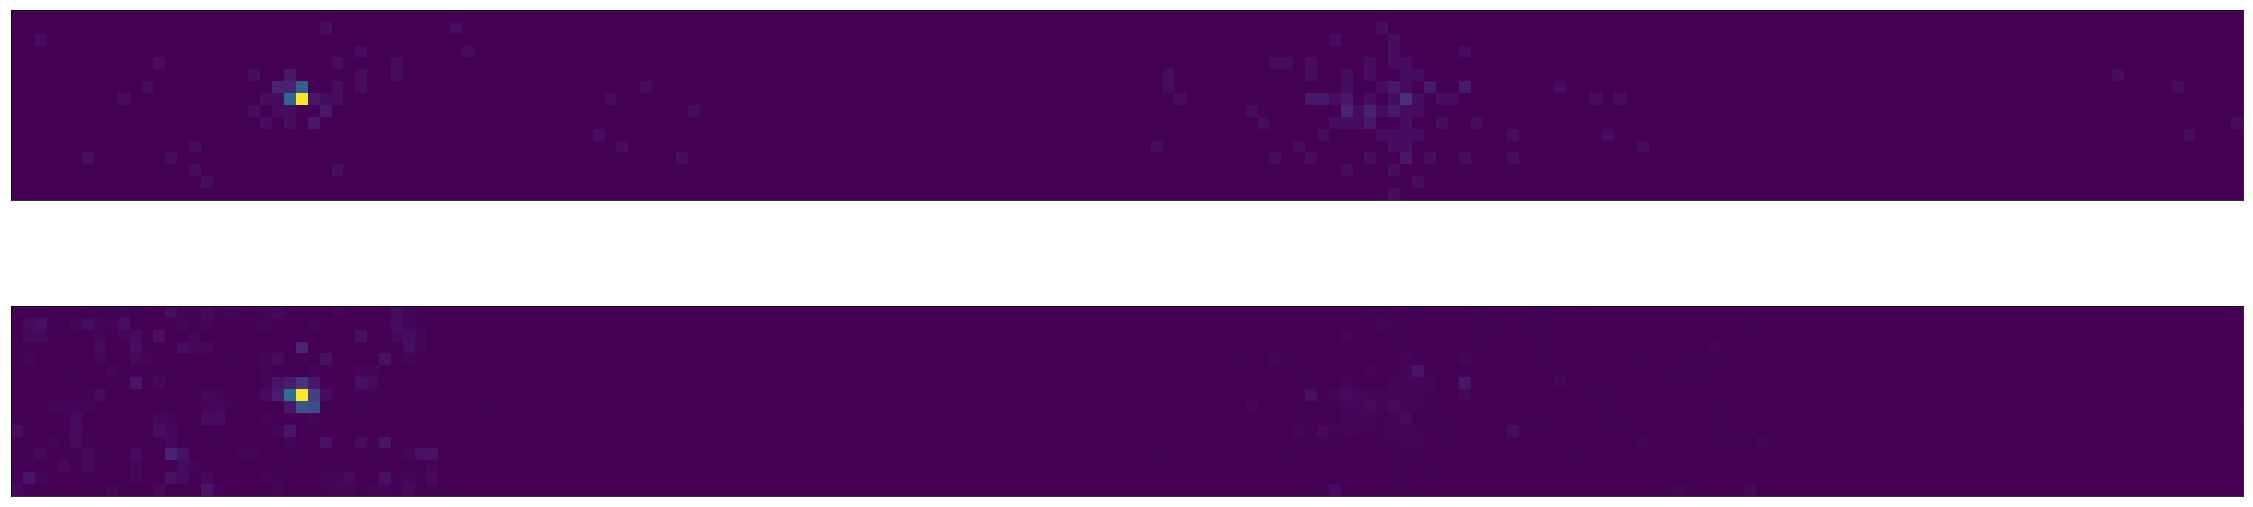

In [19]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

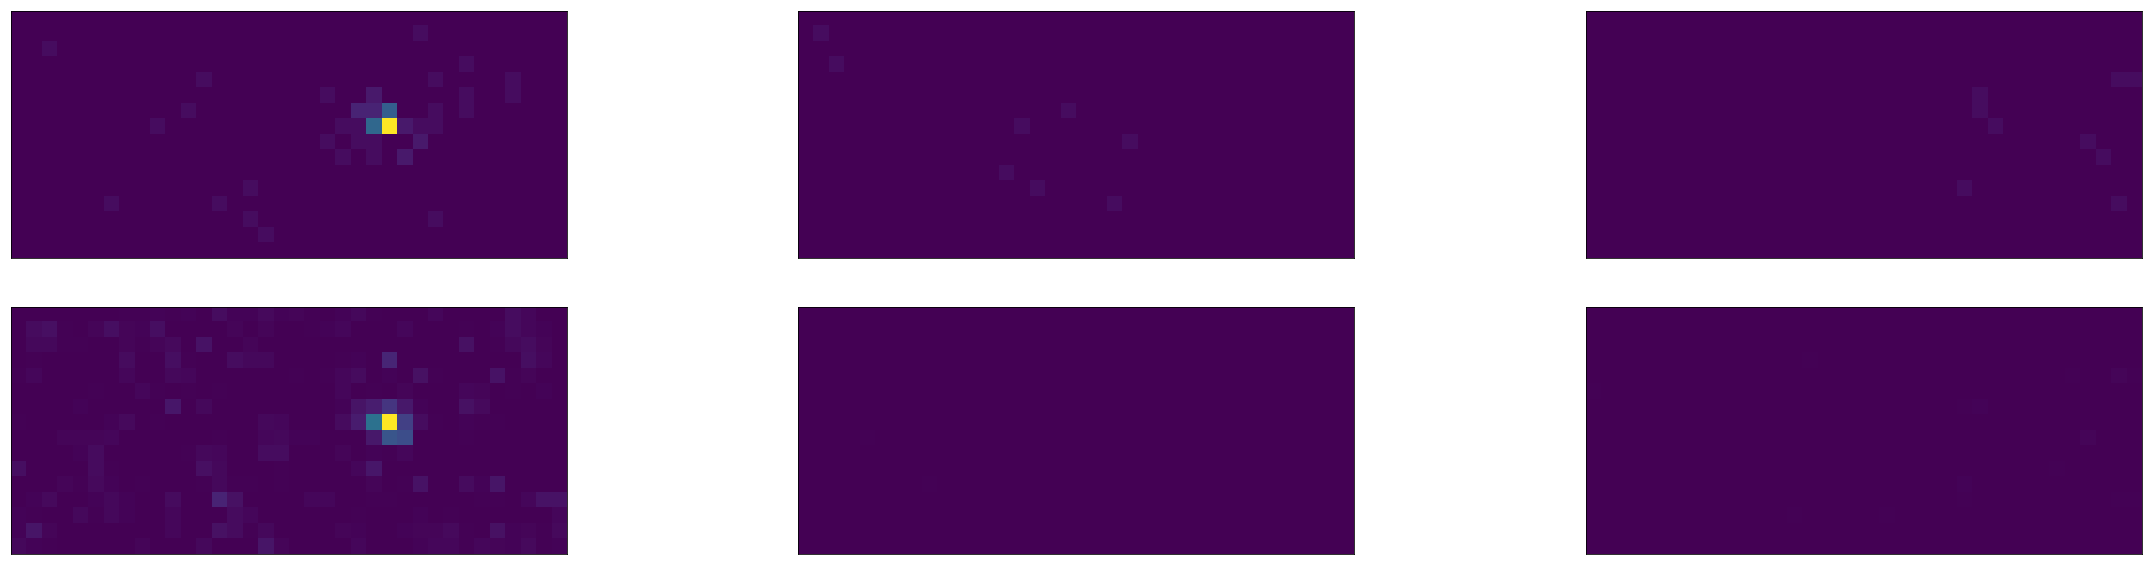

In [20]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
i=0
print(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB,img_rows)[i*img_colsA:(i+1)*img_colsA,:])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [22]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB,img_rows)[i*img_colsA:(i+1)*img_colsA,:].astype(int))

[[  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   2   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0 

Y ahora los L1B (con 40 columnas)

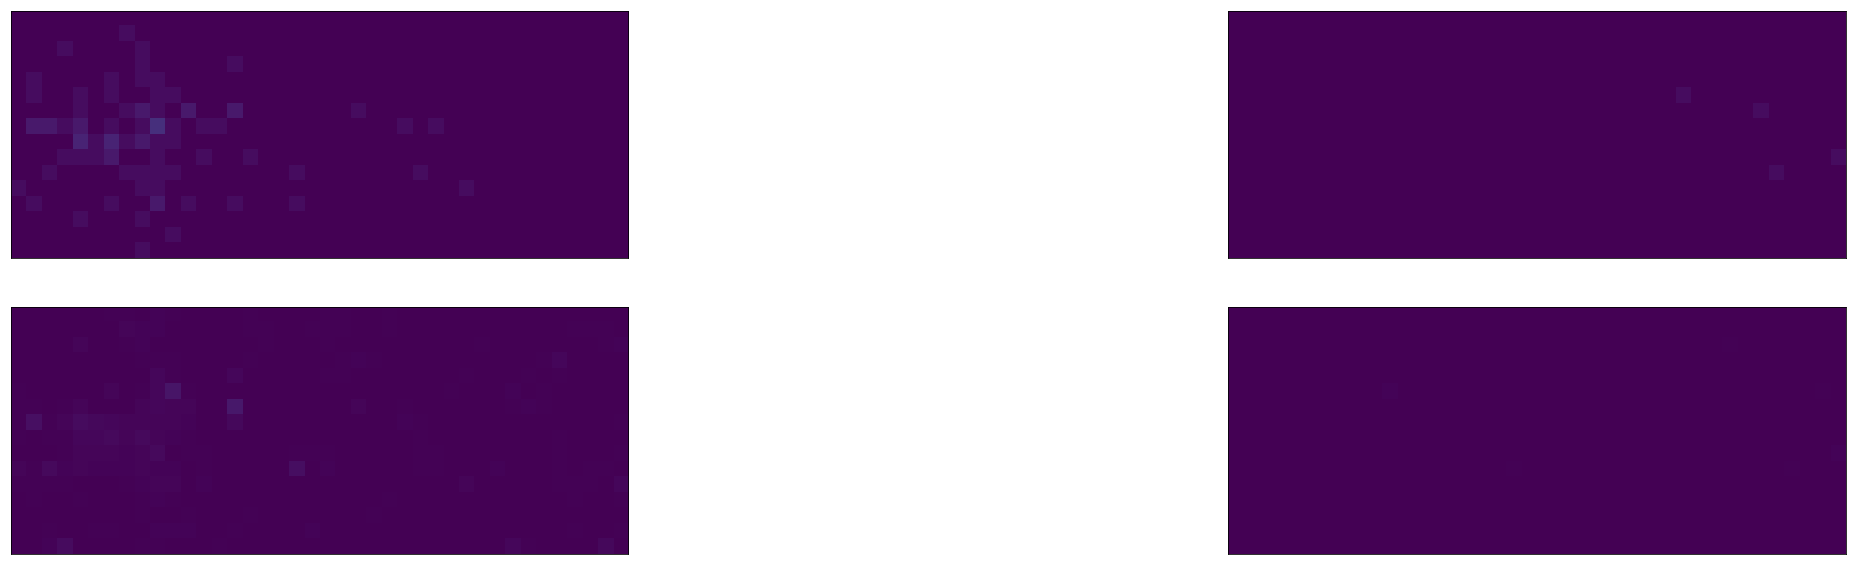

2703


In [23]:
n = L1B  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)

In [24]:
i=0
print(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB,img_rows)[L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB,:])

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 2 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 2 3 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 1 3 2 0 0 1 0 0 0]
 [0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0]
 [0 0 1 1 1 0 2 1 2 0 1 1 0 1 0 1]
 [0 0 0 0 1 1 1 4 1 1 1 1 2 0 0 0]
 [0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 2 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 

In [25]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB,img_rows)[L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB,:].astype(int))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 